**Notebook - Quality Control and Dataset Selection**

In this notebook the labelled metadata is loaded, filtered to only include compound plates and then separately the associated IBP was downloaded. This is subsequently loaded and inspected for missing values and for the underlying image quality. Then datapoints are selected based on the image quality metrics and the MOA labels.

# Imports:

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import RobustScaler, MinMaxScaler, QuantileTransformer
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold
import json
from modules.viz import discrete_colors, load_and_plot
from modules.utils import prepare_data
from modules.cleaning import find_meta_cols

%matplotlib inline
rand_seed=42

# Load Metadata with MOA Labels:

In [2]:
cwp_ki = pd.read_csv('../data/cwp_ki_moa.csv')
print(cwp_ki.shape)

(19765, 13)


In [3]:
# Exclude non-Compound Perturbations:
compound_df = cwp_ki[(cwp_ki['Metadata_PlateType']=='COMPOUND') | (
                    cwp_ki['Metadata_PlateType']=='TARGET1') | (cwp_ki['Metadata_PlateType']=='TARGET2')
                    ].reset_index(drop=True)
print(compound_df.shape)
compound_df.head(2)

(18504, 13)


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Batch,Metadata_PlateType,moa,target,smiles,clinical_phase,moa_src
0,JCP2022_037716,IVUGFMLRJOCGAS-UHFFFAOYSA-N,InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...,source_1,UL001783,B03,Batch5_20221030,COMPOUND,AURK inhibitor,AURKA|AURKB|AURKC,Cc1csc(c1)-c1nnc(Nc2ccc(Oc3ncccc3-c3ccnc(N)n3)...,Phase 1,dr_hub
1,JCP2022_037716,IVUGFMLRJOCGAS-UHFFFAOYSA-N,InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...,source_1,UL001783,B46,Batch5_20221030,COMPOUND,AURK inhibitor,AURKA|AURKB|AURKC,Cc1csc(c1)-c1nnc(Nc2ccc(Oc3ncccc3-c3ccnc(N)n3)...,Phase 1,dr_hub


In [4]:
# Remove "inhibitor" from moa label:
compound_df['moa'] = compound_df['moa'].str.replace(' inhibitor', '')

# Save to csv
# compound_df.to_csv('../data/all_cpnd_pert.csv', index=False)

# Load IBP Data:

For the compound data, matched to Kinase Inhibitor MOA labels ('all_cpnd_pert.csv'), the image-based profiles were downloaded for each datapoint from the JUMP CPG0016 Amazon S3 bucket. These were then loaded below:

In [4]:
ki_cpnd_ibp = pd.read_csv('../data/ibp/all_cpnd_ibp.csv', dtype={'clinical_phase': str})
print(ki_cpnd_ibp.shape)
# Dropping any rows where the Metadata column is "n/a"
ki_cpnd_ibp.drop(ki_cpnd_ibp[ki_cpnd_ibp.filter(like='Metadata').isna().any(axis=1)].index, inplace=True)
print(ki_cpnd_ibp.shape)
ki_cpnd_ibp.head(2)

(18504, 4774)
(18503, 4774)


,Metadata_Source,Metadata_Plate,Metadata_Well,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_BoundingBoxMinimum_X,Cells_AreaShape_BoundingBoxMinimum_Y,Cells_AreaShape_Center_X,...,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch,moa,target,smiles,clinical_phase,moa_src,Metadata_JCP2022,Metadata_InChIKey,Metadata_PlateType
0,source_1,UL001783,B03,3925.3,7554.3,556.38,540.55,469.76,455.48,512.51,...,59.381,Batch5_20221030,AURK,AURKA|AURKB|AURKC,Cc1csc(c1)-c1nnc(Nc2ccc(Oc3ncccc3-c3ccnc(N)n3)...,Phase 1,dr_hub,JCP2022_037716,IVUGFMLRJOCGAS-UHFFFAOYSA-N,COMPOUND
1,source_1,UL001783,B46,14390.0,26150.0,683.43,576.29,528.17,413.77,605.46,...,91.826,Batch5_20221030,AURK,AURKA|AURKB|AURKC,Cc1csc(c1)-c1nnc(Nc2ccc(Oc3ncccc3-c3ccnc(N)n3)...,Phase 1,dr_hub,JCP2022_037716,IVUGFMLRJOCGAS-UHFFFAOYSA-N,COMPOUND


# Inspecting N/a and Infinite Values:

In [6]:
# Create dataframe of n/a values:
missing_vals = ki_cpnd_ibp[ki_cpnd_ibp.isnull().any(axis=1) | 
                           ki_cpnd_ibp.isin([np.inf, -np.inf]).any(axis=1)].reset_index(drop=True)

In [7]:
# Get column names with NaN or infinite values and count of missing values in each column
columns_with_missing = missing_vals.columns[missing_vals.isna().any()].tolist()
missing_value_counts = missing_vals[columns_with_missing].isna().sum()

#print("Columns with missing values:", columns_with_missing)
print("Missing value counts:")
print(missing_value_counts.sort_values(ascending=False)[0:5])

Missing value counts:
Cells_AreaShape_FormFactor                  2121
Cytoplasm_AreaShape_FormFactor               419
Nuclei_Neighbors_AngleBetweenNeighbors_1       9
Nuclei_Neighbors_SecondClosestDistance_1       9
Nuclei_Neighbors_FirstClosestDistance_1        8
dtype: int64


In [7]:
def plot_dist(dataframe, measure):
    filtered_values = dataframe[measure].replace([np.inf, -np.inf], np.nan).dropna()
    plt.figure(figsize=(6, 3))
    filtered_values.plot(kind='hist', bins=50)
    plt.xlabel(measure)
    plt.ylabel('Frequency')
    plt.title('Distribution of %s \n(Excluding Infinite and N/A Values)' % measure)
    plt.show()

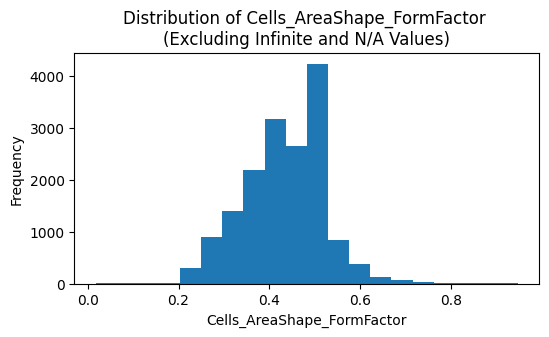

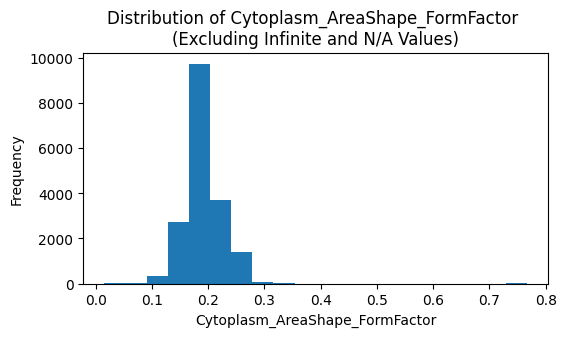

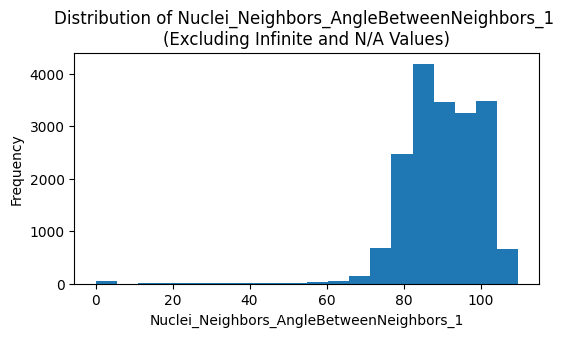

In [58]:
# Extracting columns to plot from filter above:
cols_to_plot = missing_value_counts.sort_values(ascending=False).index[0:3].tolist()

for measure in cols_to_plot:
    plot_dist(ki_cpnd_ibp, measure)

- From the plots above, due to the prescence of outliers, it appears most approapriate to replace null or infinite values in the data with the median values from that column.

## Replacing n/a or infinite values in data with the median value of that column:

In [5]:
# Replace any infinite values with "n/a":
ki_cpnd_ibp.replace([np.inf, -np.inf], np.nan, inplace=True)

# Calculate the median of each column
median_values = ki_cpnd_ibp.median(numeric_only=True)

# Replace NaN and infinite values with the median of each column
ki_cpnd_ibp.fillna(median_values, inplace=True)

# Reset index:
ki_cpnd_ibp = ki_cpnd_ibp.reset_index(drop=True)

# Adding Composite Image Quality Metric:
The CellProfiler manual contains detailed information about the ImageQuality metrics included within the IBP data: 
https://cellprofiler-manual.s3.amazonaws.com/CellProfiler-4.0.5/modules/measurement.html

From this we can select columns which represent the relative blur, saturation and focus of the original microscopy images and use these to perform some quality control before selecting samples.


In [6]:
# All columns relating to the below metrics contain the following substrings:
blur = ['ImageQuality_Correlation', 'ImageQuality_PowerLogLogSlope']
saturation = ['ImageQuality_PercentMaximal', 'ImageQuality_PercentMinimal']
focus = ['ImageQuality_Focus', 'ImageQuality_LocalFocus']
quality_metrics = blur + saturation + focus

# List of columns for each measure:
blur_cols = [col for col in ki_cpnd_ibp.columns if any(
                    substring in col for substring in blur)]
sat_cols = [col for col in ki_cpnd_ibp.columns if any(
                    substring in col for substring in saturation)]
focus_cols = [col for col in ki_cpnd_ibp.columns if any(
                    substring in col for substring in focus)]
metrics_cols = [col for col in ki_cpnd_ibp.columns if any(
                    substring in col for substring in quality_metrics)]

In [9]:
print("Blur Features: ", len(blur_cols))
print("Saturation Features: ", len(sat_cols))
print("Focus Features: ", len(focus_cols))

Blur Features:  25
Saturation Features:  10
Focus Features:  25


## Normalize metrics data:

In [10]:
# Subsetting dataframe to only include metric columns:
metrics_data = ki_cpnd_ibp[metrics_cols]

In [11]:
# Define a scaler for normalization:
scaler = MinMaxScaler()

# Normalize:
metrics_data_norm = pd.DataFrame(scaler.fit_transform(metrics_data), 
                             columns=metrics_data.columns.tolist())

In [12]:
metrics_data_norm.isnull().values.any()

False

## Score According to Metric Type:

### Taking Mean Metric of Each Column for Datapoint:

In [27]:
# Score according to each metric type:
blur_score = metrics_data_norm[blur_cols].mean(axis=1)
sat_score = metrics_data_norm[sat_cols].mean(axis=1)
focus_score = metrics_data_norm[focus_cols].mean(axis=1)

# Composite score (higher focus = higher quality)
comp_score = blur_score + sat_score - focus_score

In [28]:
print("Blur Scores: ", blur_score[0:3].values)
print("Saturation Scores: ", sat_score[0:3].values)
print("Focus Scores: ", focus_score[0:3].values)
print('------------------------------------------------------')
print("Composite Scores: ", comp_score[0:3].values)

Blur Scores:  [0.53695703 0.55615643 0.55068477]
Saturation Scores:  [0.00026647 0.00021367 0.00045475]
Focus Scores:  [0.06791346 0.09024024 0.09713064]
------------------------------------------------------
Composite Scores:  [0.46931005 0.46612986 0.45400889]


### Transforming Saturation to Normal Dist. and Inverting Focus Score:
- Saturation is heavily right skewed and so was largely playing no part in the overall quality metric scores (see above saturation values). Here we converted it's distribution to normal before taking the metric values.

In [15]:
quantile_transformer = QuantileTransformer(output_distribution='normal')
fs = np.array(metrics_data_norm[sat_cols].mean(axis=1))
transformed_values = quantile_transformer.fit_transform(fs.reshape(-1, 1))
transformed_values = (transformed_values - transformed_values.min()) / (
    transformed_values.max() - transformed_values.min())
alt_sat_vals = [x[0] for x in transformed_values]

In [19]:
focus = metrics_data_norm[focus_cols].mean(axis=1).max() - \
                    metrics_data_norm[focus_cols].mean(axis=1)

In [23]:
# Composite score (higher (inverted) focus = low quality)
comp_score = blur_score + alt_sat_vals + focus

In [24]:
print("Blur Scores: ", blur_score[0:3].values)
print("Saturation Scores: ", alt_sat_vals[0:3])
print("Focus Scores: ", focus[0:3].values)
print('------------------------------------------------------')
print("Composite Scores: ", comp_score[0:3].values)

Blur Scores:  [0.53695703 0.55615643 0.55068477]
Saturation Scores:  [0.5431725253824337, 0.5375073581763702, 0.5615762755773205]
Focus Scores:  [0.4654426  0.44311581 0.43622542]
------------------------------------------------------
Composite Scores:  [1.54557215 1.5367796  1.54848647]


### Transforming Saturation Using Tanh:
- After converting saturation to a normal distribution above it was observed that both highly saturated and highly unsaturated images were of a poor quality. 

In [55]:
def tanh_tform(x, a=5, b=0.5):
    return np.abs(np.tanh(a * (x - b)))

In [56]:
tanh_sat = tanh_tform(np.array(alt_sat_vals), b=np.median(alt_sat_vals)).tolist()

In [57]:
# Composite score (higher (inverted) focus = low quality)
comp_score = blur_score + tanh_sat + focus

In [58]:
print("Blur Scores: ", blur_score[0:3].values)
print("Saturation Scores: ", tanh_sat[0:3])
print("Focus Scores: ", focus[0:3].values)
print('------------------------------------------------------')
print("Composite Scores: ", comp_score[0:3].values)

Blur Scores:  [0.53695703 0.55615643 0.55068477]
Saturation Scores:  [0.21509207291037852, 0.18791842772169173, 0.3009129126120505]
Focus Scores:  [0.4654426  0.44311581 0.43622542]
------------------------------------------------------
Composite Scores:  [1.2174917  1.18719067 1.2878231 ]


## Updating Original Data:

In [63]:
ki_cpnd_ibp['blur_score'] = blur_score
ki_cpnd_ibp['sat_score'] = tanh_sat
ki_cpnd_ibp['focus_score'] = focus
ki_cpnd_ibp['comp_score'] = comp_score

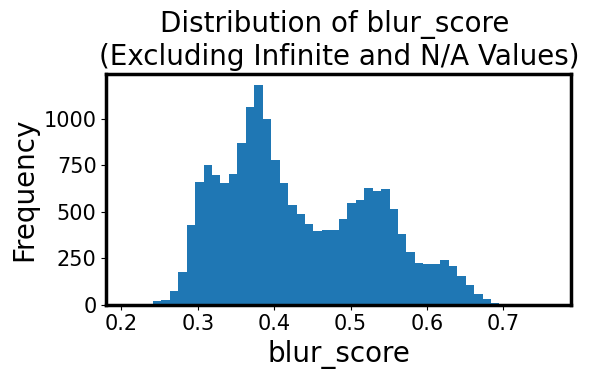

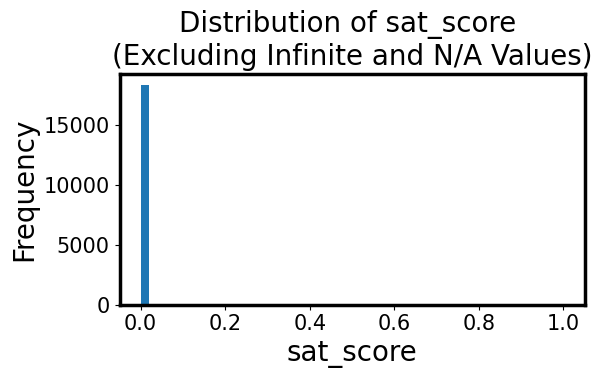

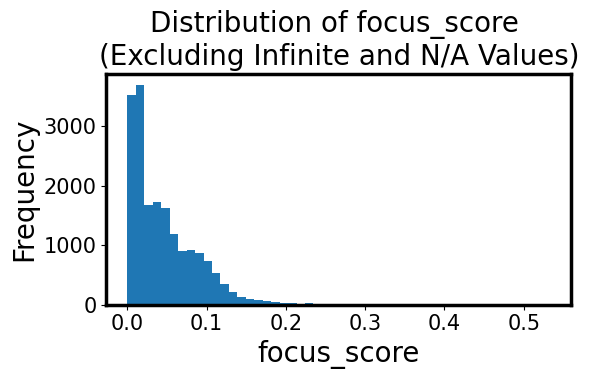

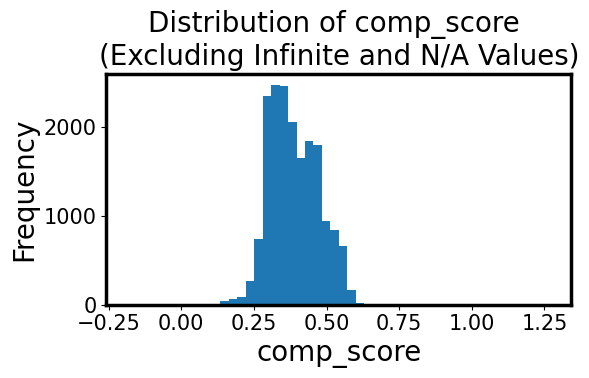

In [18]:
score_cols = ['blur_score', 'sat_score', 'focus_score', 'comp_score']

for col in score_cols:
    plot_dist(ki_cpnd_ibp, col)

### Normalized the Saturation Scores:

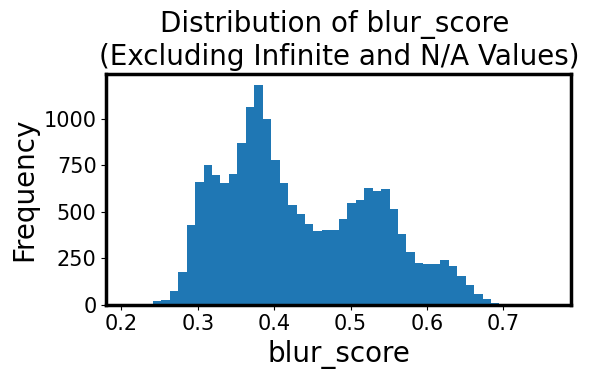

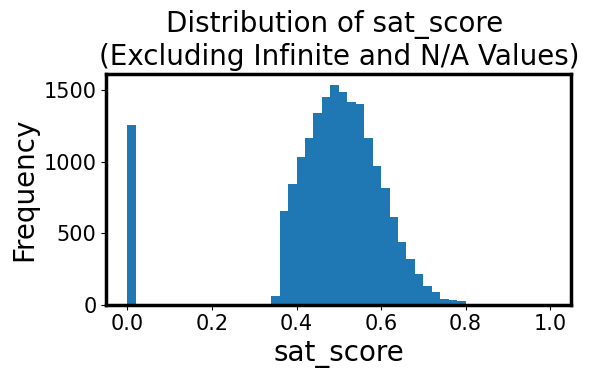

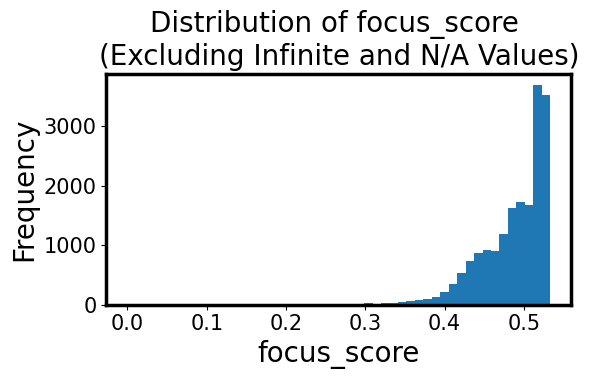

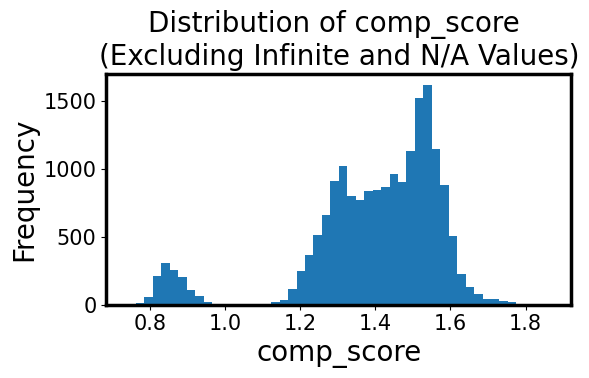

In [58]:
score_cols = ['blur_score', 'sat_score', 'focus_score', 'comp_score']

for col in score_cols:
    plot_dist(ki_cpnd_ibp, col)

### Tanh the Normalized Saturation Scores:

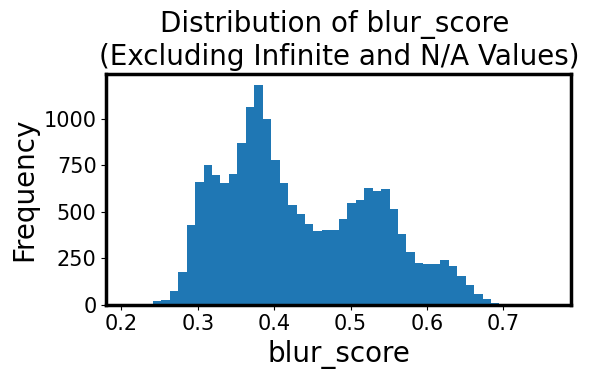

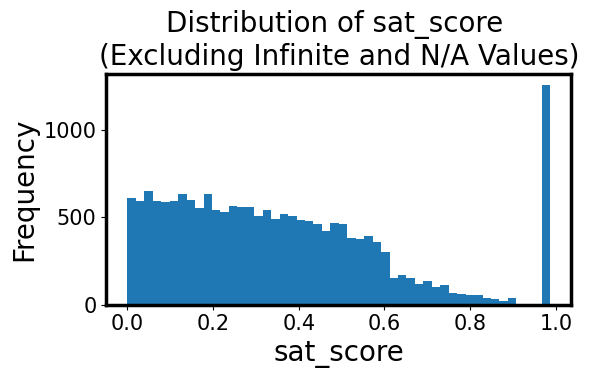

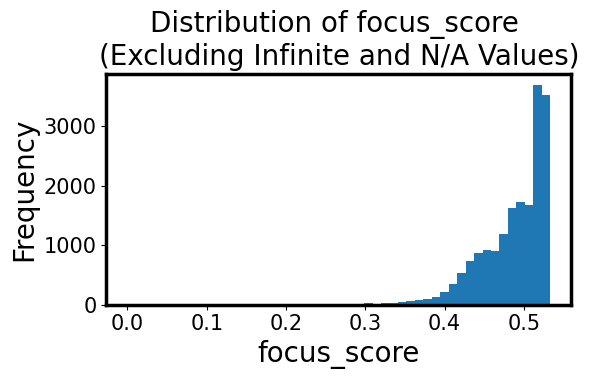

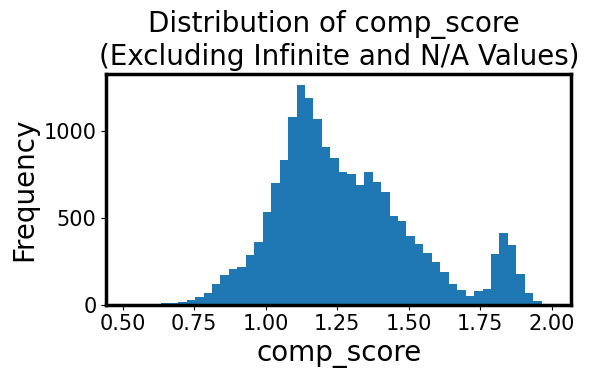

In [64]:
score_cols = ['blur_score', 'sat_score', 'focus_score', 'comp_score']

for col in score_cols:
    plot_dist(ki_cpnd_ibp, col)

## Plot Quality Metrics According to Source:

In [61]:
def plot_source_dist(dataframe, measure, cmap):
    filtered_values = dataframe[measure].replace(
        [np.inf, -np.inf], np.nan).dropna()
    
    # Get the unique values in the 'Metadata_Source' column
    unique_sources = dataframe['Metadata_Source'].unique()
    
    # Sort according to source number:
    sorted_sources = sorted(unique_sources, 
                         key=lambda x: int(''.join(filter(str.isdigit, x))))

    # Plot the histogram with colored and stacked bars
    plt.figure(figsize=(12, 8))
    plt.hist([filtered_values[dataframe['Metadata_Source'] == source
                             ] for source in sorted_sources],
             bins=50, stacked=True, color=cmap, label=sorted_sources)

    plt.xlabel(measure)
    plt.ylabel('Frequency')
    plt.title('Distribution of %s' % measure)
    plt.legend(loc='upper right')
    plt.show()

### Original Metrics:

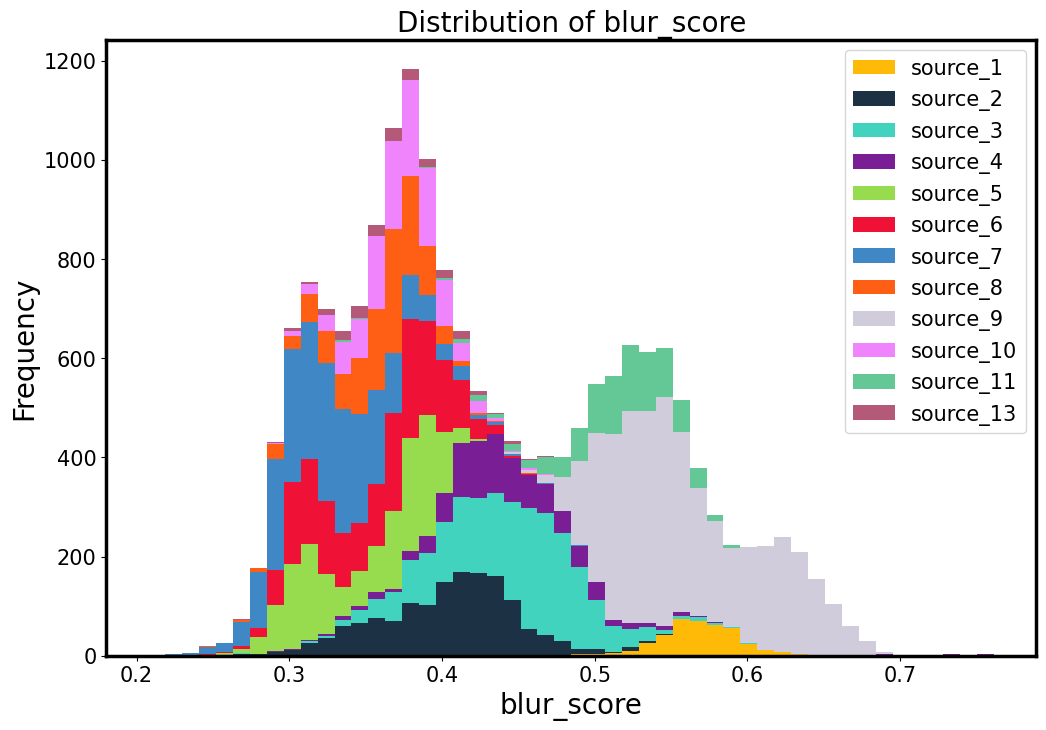

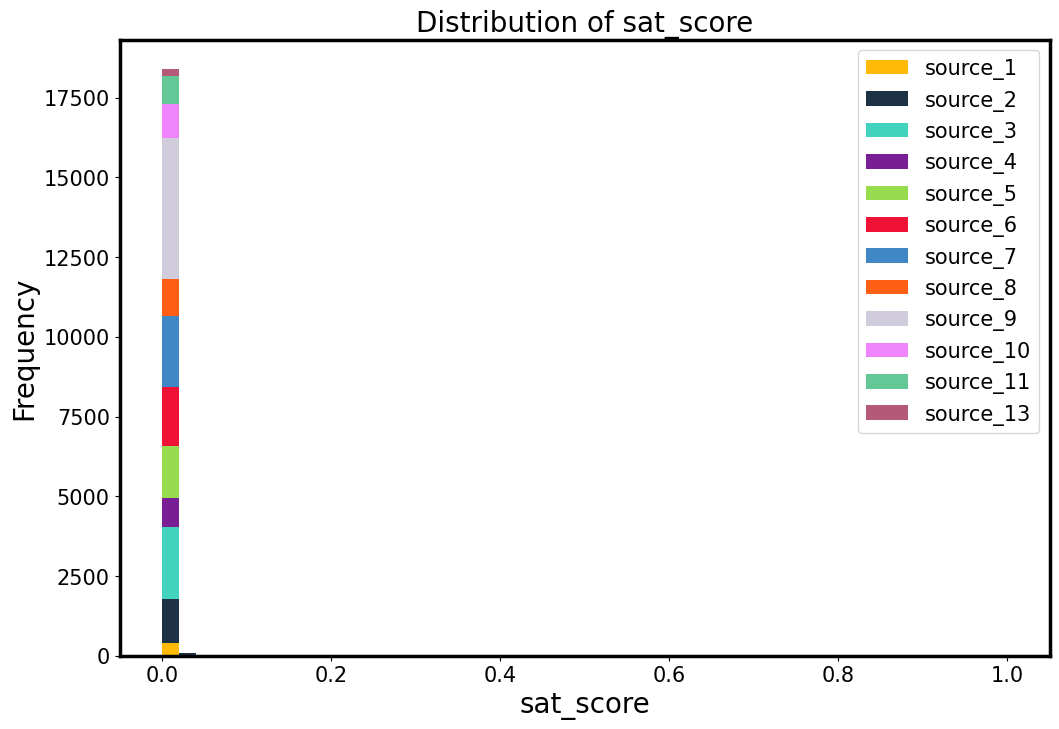

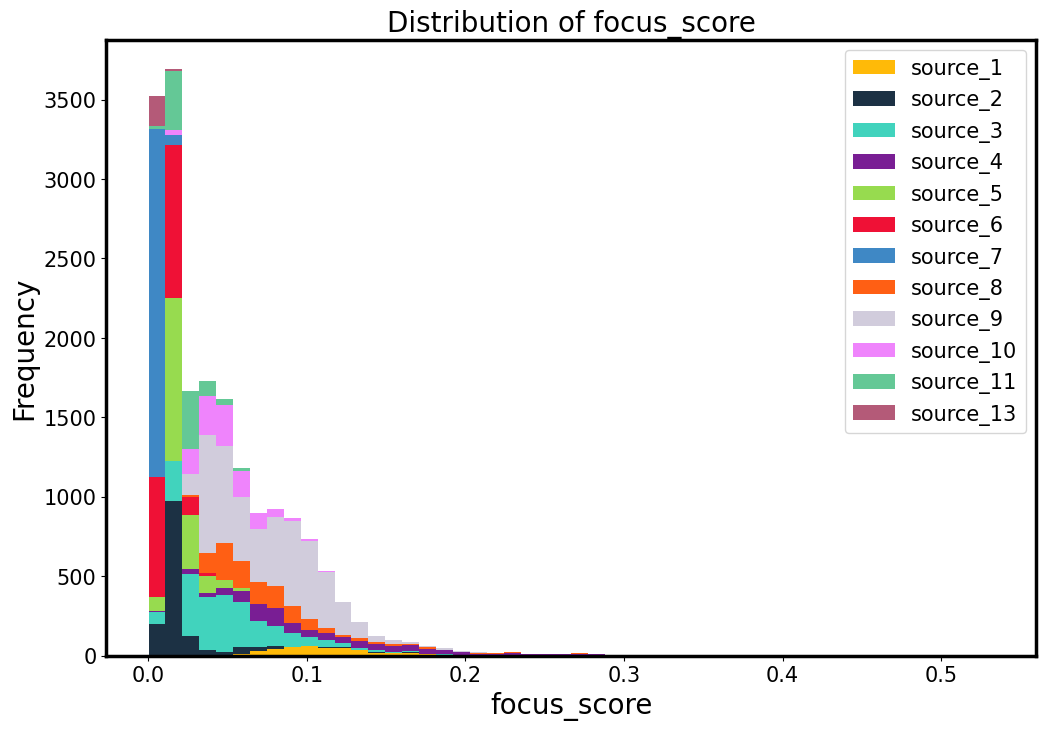

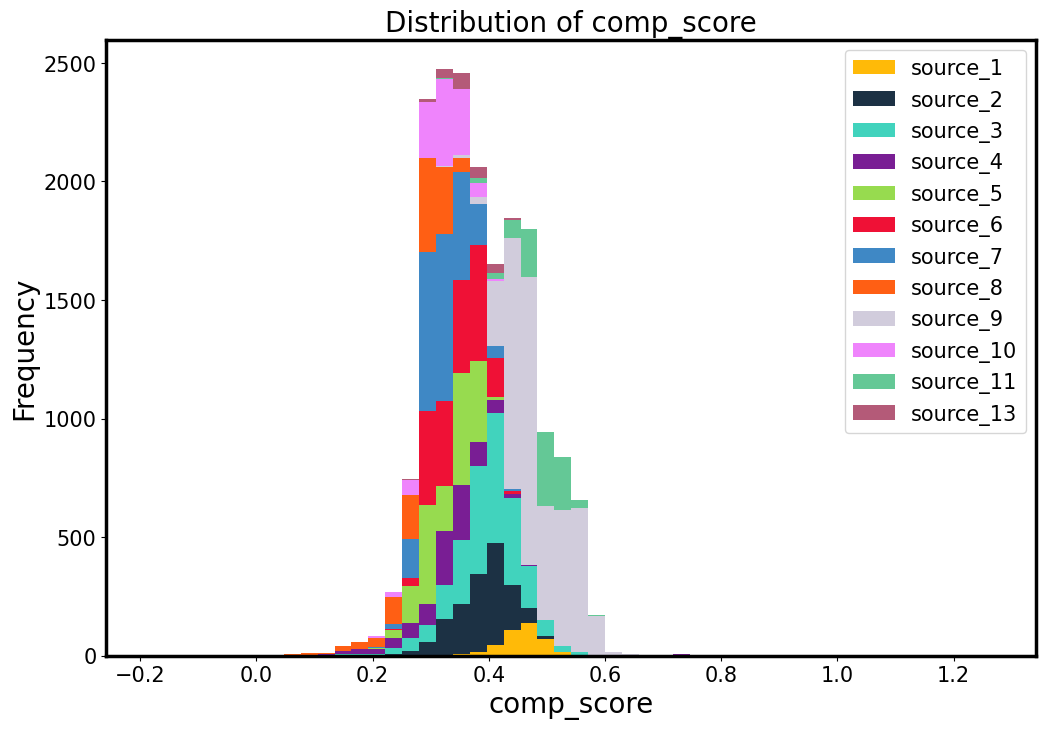

In [20]:
# Return a list of colors for the sources:
cmap = discrete_colors(len(ki_cpnd_ibp['Metadata_Source'].unique()), 'rgb')

# Plot:
for col in score_cols:
    plot_source_dist(ki_cpnd_ibp, col, cmap)

### Normalized Saturation and Inverted Focus:

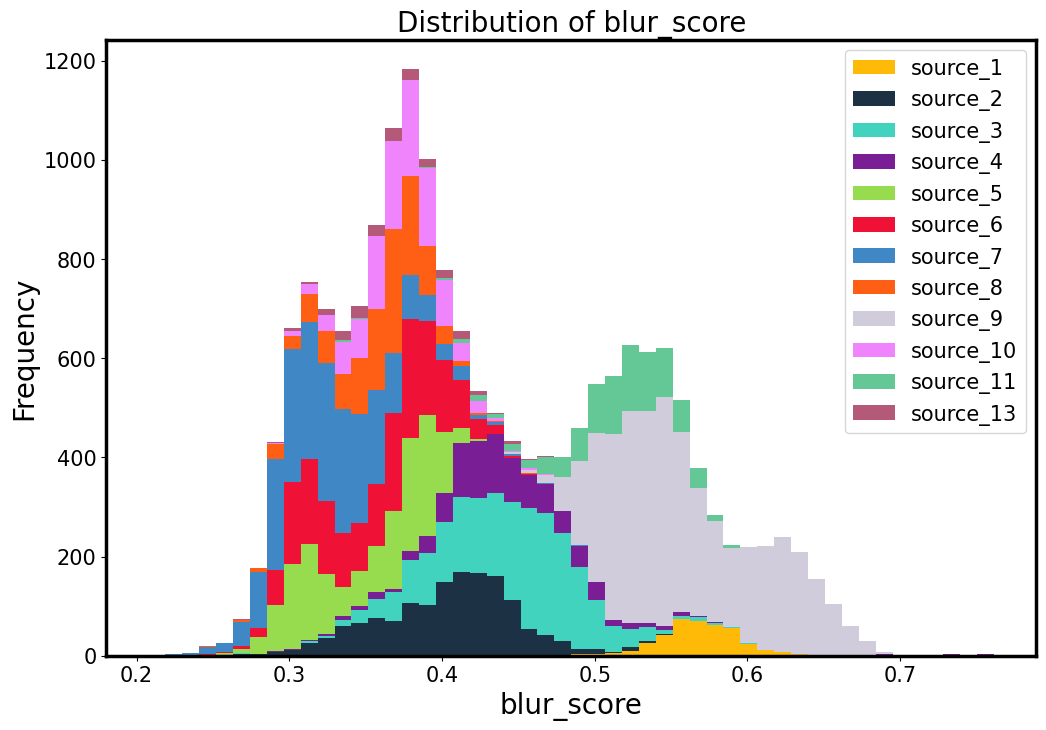

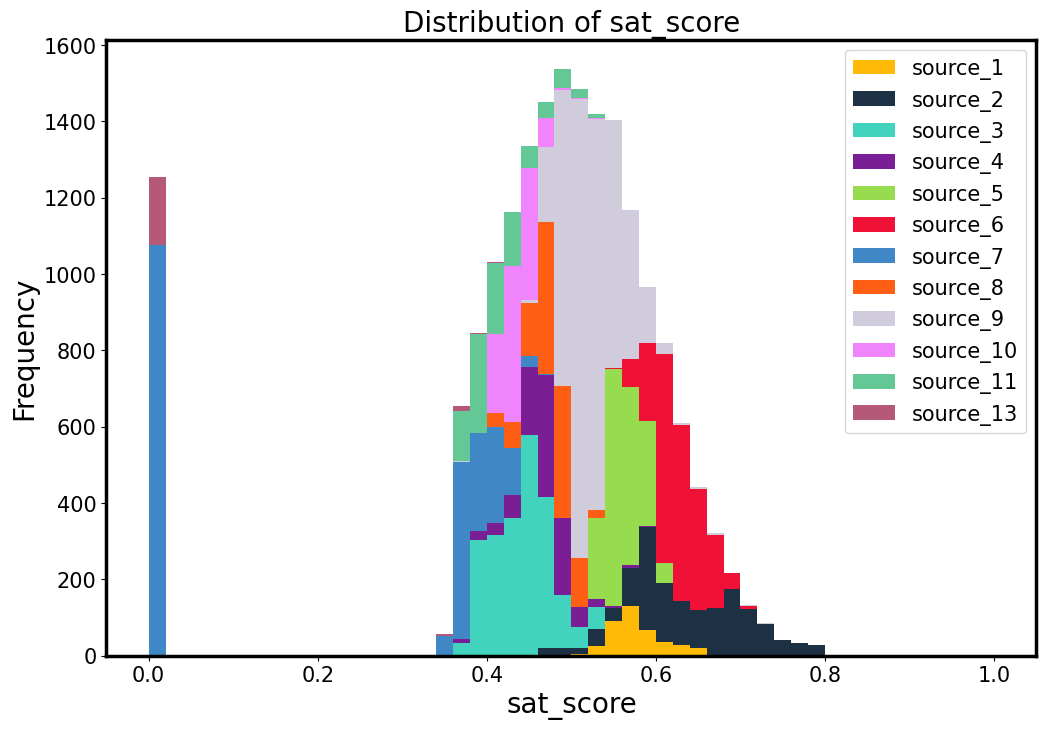

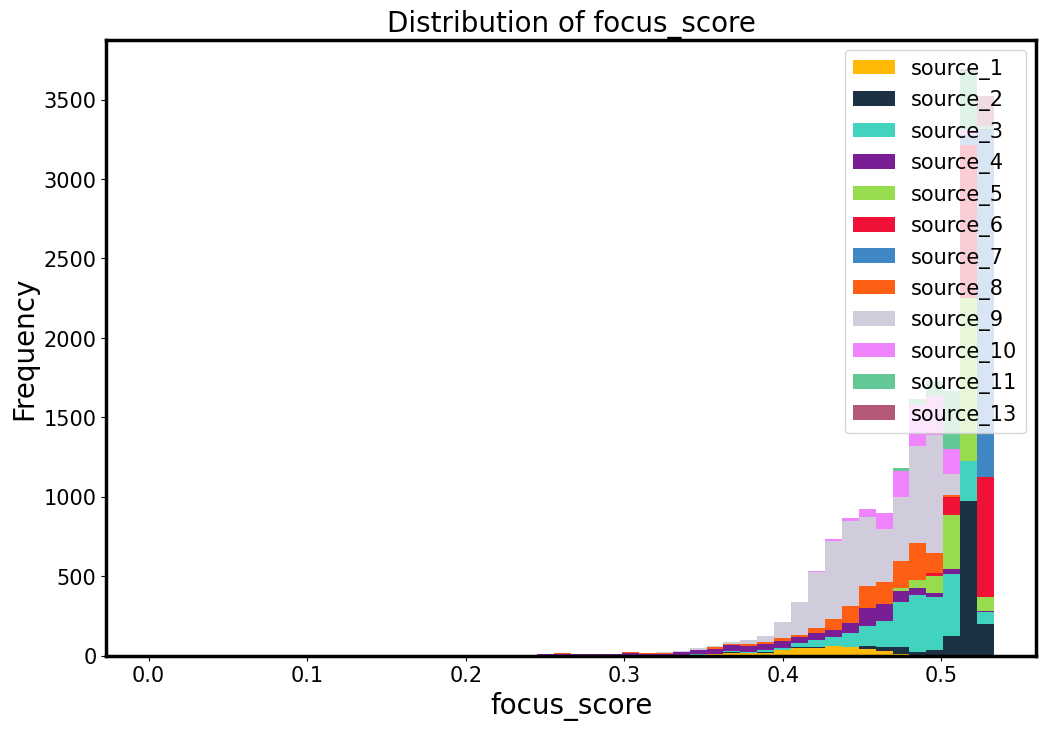

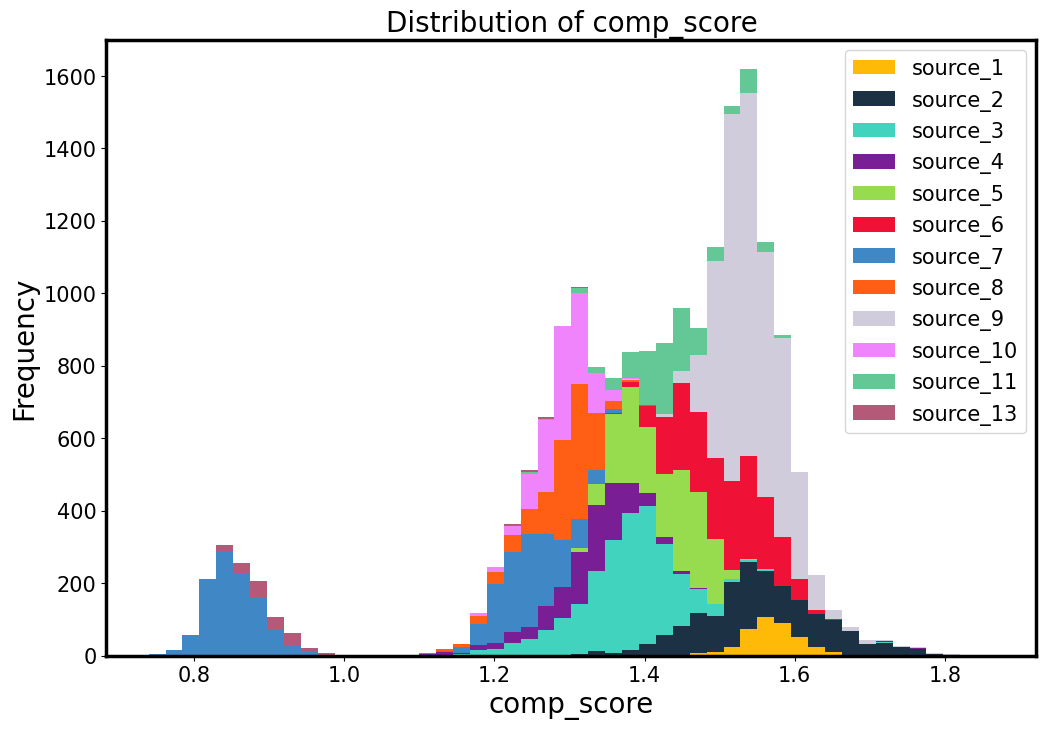

In [60]:
# Return a list of colors for the sources:
cmap = discrete_colors(len(ki_cpnd_ibp['Metadata_Source'].unique()), 'rgb')

# Plot:
for col in score_cols:
    plot_source_dist(ki_cpnd_ibp, col, cmap)

### Tanh Normalized Saturation and Inverted Focus:

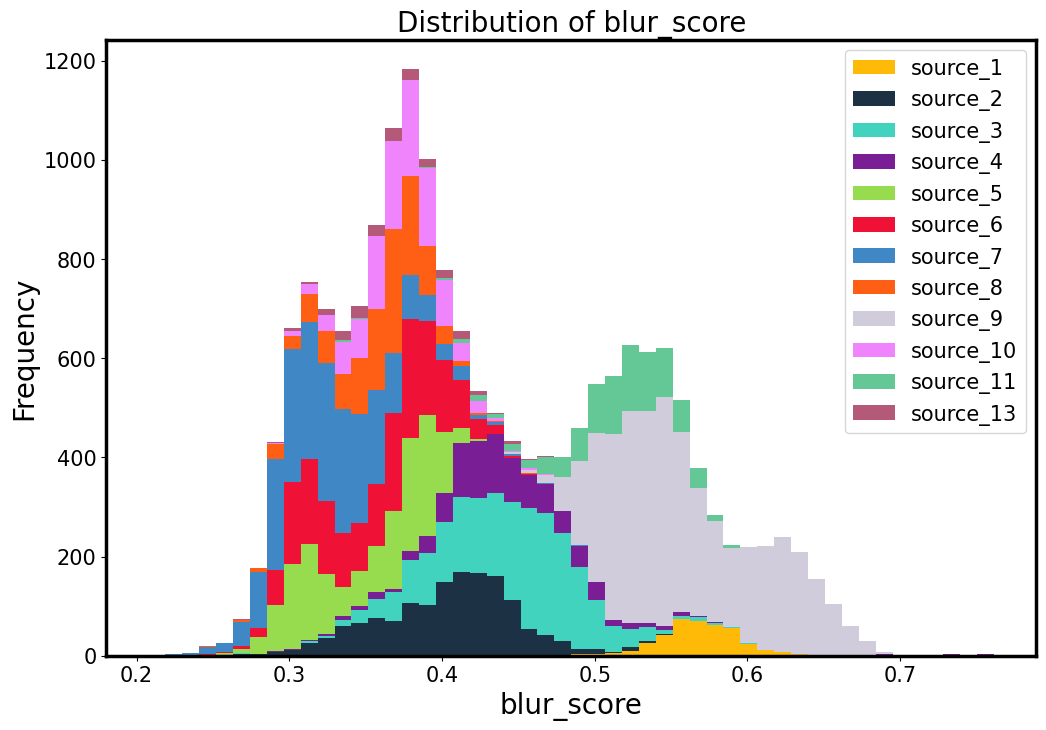

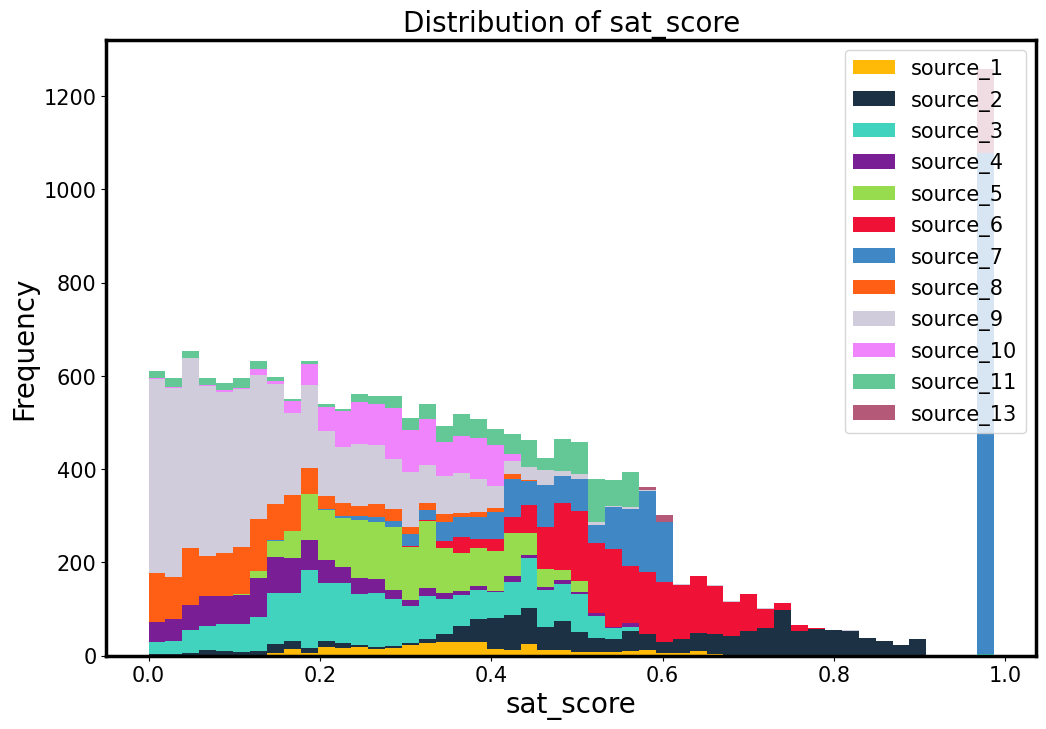

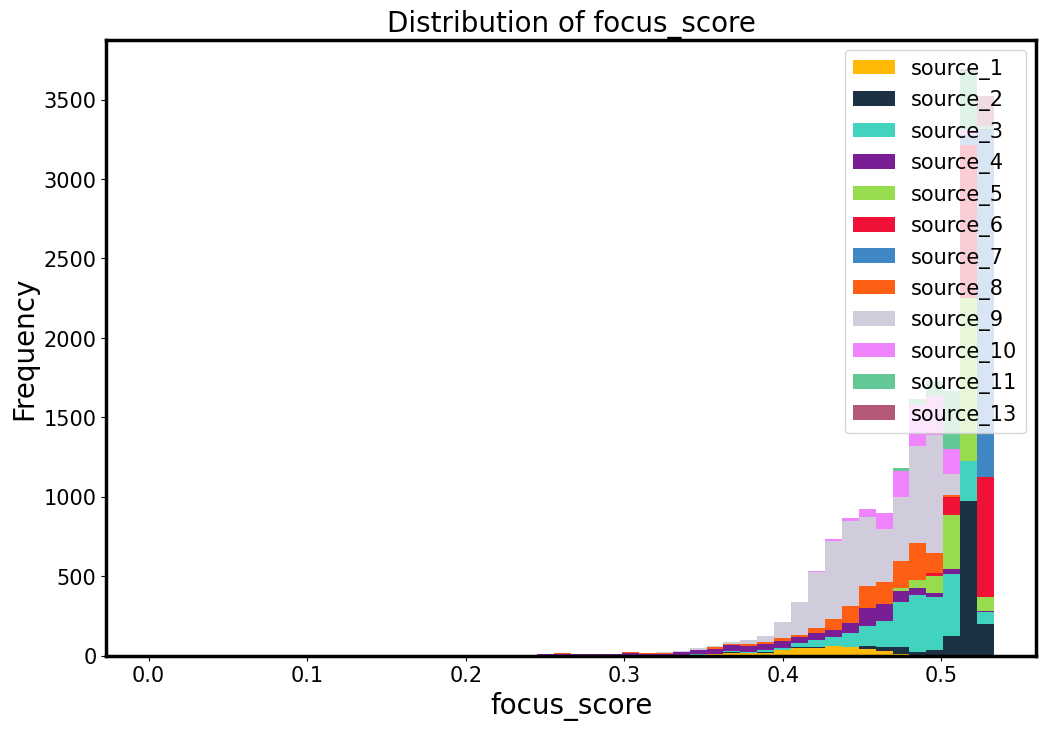

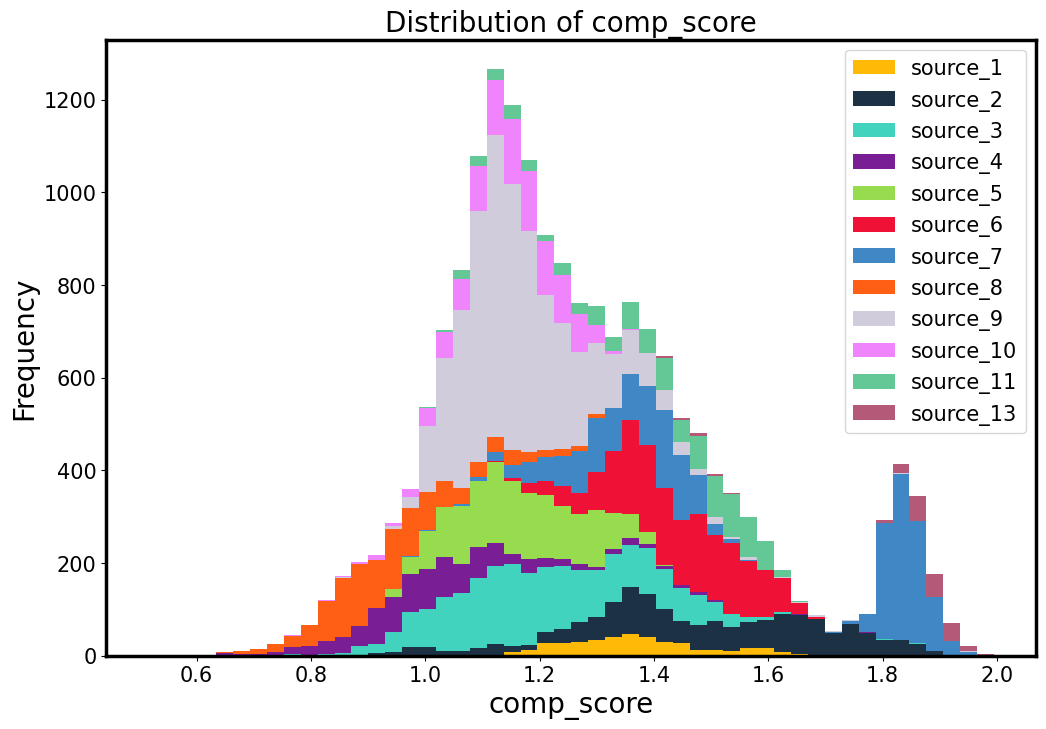

In [65]:
# Return a list of colors for the sources:
cmap = discrete_colors(len(ki_cpnd_ibp['Metadata_Source'].unique()), 'rgb')

# Plot:
for col in score_cols:
    plot_source_dist(ki_cpnd_ibp, col, cmap)

In [67]:
ki_cpnd_ibp.to_csv('../data/cpnd_quality_moa.csv', index=False)

# Filtering Low Quality Data:
- Datapoints in the 90th percentiles of either the blur, saturation or focus columns are excluded from being picked in the dataset.

In [68]:
perc_chosen = 0.9
blur_perc = ki_cpnd_ibp['blur_score'].quantile(perc_chosen)
print("Blur Cutoff: ", blur_perc)
sat_perc = ki_cpnd_ibp['sat_score'].quantile(perc_chosen)
print("Sat. Cutoff: ", sat_perc)
focus_perc = ki_cpnd_ibp['focus_score'].quantile(perc_chosen)
print("Focus Cutoff: ", focus_perc)

Blur Cutoff:  0.5705407633802638
Sat. Cutoff:  0.7091832007298398
Focus Cutoff:  0.5279552845238193


In [92]:
print("Before Filtering, shape: ", ki_cpnd_ibp.shape)
quality_data = ki_cpnd_ibp[(ki_cpnd_ibp['blur_score'] < blur_perc) & (ki_cpnd_ibp['sat_score'] < sat_perc) 
                          & (ki_cpnd_ibp['focus_score'] < focus_perc)].reset_index(drop=True)
print("Post Filtering, shape: ", quality_data.shape)

Before Filtering, shape:  (18503, 4778)
Post Filtering, shape:  (13951, 4778)


## Inspecting Replicates:

In [93]:
select_kis = ["PI3K", "EGFR", "HER2", "p38 MAPK", "JAK", "RAF", "AURK", "ROCK", "ALK", "SRC", "MEK",
               "GSK", "CDK", "VEGFR", "Bcr-Abl", "PDGFR", "FGFR", "BTK", "AKT", "mTOR"]

In [95]:
moa_reps = pd.DataFrame(quality_data.groupby(['Metadata_JCP2022','moa'])['moa'].count()).rename(
                                                                columns={'moa': 'replicates'}).reset_index()

moa_reps.sort_values('replicates', ascending=False).head(15)

,Metadata_JCP2022,moa,replicates
91,JCP2022_037716,AURK,7165
28,JCP2022_013856,PI3K,336
79,JCP2022_032771,CDK,321
215,JCP2022_104437,CDK,170
167,JCP2022_077046,PDGFR|VEGFR,170
80,JCP2022_033954,p38 MAPK,167
26,JCP2022_013455,FGFR|PDGFR|VEGFR,167
205,JCP2022_098688,ALK,167
98,JCP2022_041139,JAK,164
56,JCP2022_024824,ROCK,163


In [78]:
moa_reps.moa.unique()

array(['EGFR', 'MEK', 'PI3K', 'CDK', 'ALK|EGFR', 'mTOR', 'AURK',
       'Bcr-Abl|SRC', 'CDK|GSK', 'VEGFR', 'EGFR|HER2', 'RAF', 'JAK',
       'SRC', 'FGFR', 'Bcr-Abl', 'GSK', 'PI3K|mTOR', 'AKT', 'p38 MAPK',
       'EGFR|JAK', 'FGFR|VEGFR', 'FGFR|PDGFR|VEGFR', 'PDGFR',
       'PDGFR|VEGFR', 'EGFR/HER2|HER2', 'EGFR|RAF', 'ROCK', 'BTK|EGFR',
       'Bcr-Abl|FGFR|PDGFR|RAF|VEGFR|p38 MAPK', 'ALK', 'AURK|Bcr-Abl',
       'EGFR|p38 MAPK', 'BTK', 'AURK|VEGFR', 'EGFR|HER2|SRC', 'EGFR/HER2',
       'EGFR|FGFR|PDGFR|SRC', 'PI3K/mTOR', 'Bcr-Abl|PDGFR', 'MEK|RAF',
       'AURK|Bcr-Abl|JAK', 'EGFR|mTOR', 'AKT|GSK', 'PDGFR|RAF|VEGFR',
       'EGFR|FGFR|PDGFR|VEGFR', 'AKT|MEK', 'AKT|GSK|p38 MAPK',
       'EGFR|SRC|VEGFR', 'BTK|EGFR|EGFR/HER2', 'FGFR|PDGFR|SRC',
       'AURK|PDGFR|SRC|VEGFR', 'RAF|VEGFR', 'Bcr-Abl|SRC|VEGFR',
       'Bcr-Abl|PDGFR|SRC', 'AKT|GSK|MEK', 'EGFR|EGFR/HER2'], dtype=object)

# Selecting Datapoints:

In [121]:
# Splitting kinase inhibitors into two sets based on expected expression in U2OS cells:
high_ki = ["PI3K", "EGFR", "p38 MAPK", "RAF", "AURK", "ROCK", "MEK", "GSK", "CDK", "mTOR"] # "AKT",
#high_filter = "PI3K|^EGFR|p38 MAPK|RAF|AURK|ROCK|MEK|GSK|CDK|AKT|mTOR"

low_ki = ["JAK", "VEGFR", "Bcr-Abl", "PDGFR", "FGFR", "BTK", "ALK", "SRC"]
#low_filter = "JAK|VEGFR|Bcr-Abl|PDGFR|FGFR|BTK|ALK|SRC"

In [122]:
def create_dataset(compound_df, reps_df, kinase_lst, min_reps=4, max_reps=5, random_state=42):
    select_data = []
    selected_ids = []
    
    # Select random samples (n=max_replicates) from the compound dataframe:
    for ki in kinase_lst:
        # Unique compound IDs for selected inhibitor:
        uniq_c = compound_df[compound_df['moa']== ki].reset_index(drop=True).Metadata_JCP2022.unique().tolist()

        for c in uniq_c:
            if c not in selected_ids:
                # Filter dataframe according to moa and compound id:
                filt_df = compound_df.loc[compound_df['moa']== ki].loc[
                                            compound_df['Metadata_JCP2022']==c]

                # Split filt_df into two DataFrames: one for "target" is not "Not listed",
                # and another for "target" is "Not listed", then shuffle the data:
                has_target_mask = filt_df['target'] != 'Not listed'
                has_target_df = filt_df[has_target_mask].sample(frac=1, random_state=random_state)
                no_target_df = filt_df[~has_target_mask].sample(frac=1, random_state=random_state)

                # Prioritize sampling from rows where "target" is not "Not listed":
                concat_df = pd.concat([has_target_df, no_target_df])

                # Sample data subset, choosing a maximum of X replicates:               
                if len(concat_df) < min_reps:
                    print("Not enough replicates, passing %s - %s..." %(c, ki))
                else:
                    selection = concat_df.iloc[:max_reps]

                    # Add selection to list outside loop and update tracked compound ID list:
                    select_data.append(selection.values)
                    [selected_ids.append(x) for x in selection.Metadata_JCP2022.values.tolist()]
            else:
                pass

    # Create dataframe of selected samples:
    moa_df = pd.DataFrame(np.concatenate(select_data), columns=compound_df.columns)
    
    # Remove any moas not in selected moas:
    def remove_substrings(row):
        # Split the moa string by "|"
        moa_list = row['moa'].split('|')
        # Keep only the substrings that are in the high_ki list
        k_list = [s.replace('^', '') for s in kinase_lst]
        moa_list = [x for x in moa_list if x in k_list]
        # Join the remaining substrings with "|"
        return '|'.join(moa_list)
    
    moa_df['moa'] = moa_df.apply(remove_substrings, axis=1)
    
    return moa_df

# Kinase Inhibitor Dataset:

In [128]:
high_ki_df = create_dataset(quality_data, moa_reps, high_ki, max_reps=10, random_state=42)
print(high_ki_df.shape)
high_ki_df.head(10)

Not enough replicates, passing JCP2022_046274 - PI3K...
Not enough replicates, passing JCP2022_030096 - PI3K...
Not enough replicates, passing JCP2022_080273 - EGFR...
Not enough replicates, passing JCP2022_018382 - EGFR...
Not enough replicates, passing JCP2022_036764 - EGFR...
Not enough replicates, passing JCP2022_109712 - p38 MAPK...
Not enough replicates, passing JCP2022_047206 - RAF...
Not enough replicates, passing JCP2022_103653 - AURK...
Not enough replicates, passing JCP2022_076804 - AURK...
Not enough replicates, passing JCP2022_099305 - AURK...
Not enough replicates, passing JCP2022_081123 - MEK...
Not enough replicates, passing JCP2022_107177 - GSK...
Not enough replicates, passing JCP2022_092591 - CDK...
Not enough replicates, passing JCP2022_066250 - CDK...
Not enough replicates, passing JCP2022_001418 - CDK...
Not enough replicates, passing JCP2022_099219 - CDK...
(635, 4778)


,Metadata_Source,Metadata_Plate,Metadata_Well,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_BoundingBoxMinimum_X,Cells_AreaShape_BoundingBoxMinimum_Y,Cells_AreaShape_Center_X,...,smiles,clinical_phase,moa_src,Metadata_JCP2022,Metadata_InChIKey,Metadata_PlateType,blur_score,sat_score,focus_score,comp_score
0,source_3,JCPQC023,G14,3227.817708,5310.328125,589.21875,541.552083,519.484375,471.942708,553.446757,...,Nc1cc(c(cn1)-c1cc(nc(n1)N1CCOCC1)N1CCOCC1)C(F)...,Phase 3,dr_hub,JCP2022_013856,CWHUFRVAEUJCEF-UHFFFAOYSA-N,TARGET2,0.430742,0.453621,0.517562,1.401925
1,source_4,BR00121424,G14,4255.3,7338.3,572.7,554.5,488.42,470.49,530.26,...,Nc1cc(c(cn1)-c1cc(nc(n1)N1CCOCC1)N1CCOCC1)C(F)...,Phase 3,dr_hub,JCP2022_013856,CWHUFRVAEUJCEF-UHFFFAOYSA-N,TARGET2,0.436727,0.144924,0.386009,0.967661
2,source_9,GR00003340,D35,3071.3,5623.0,573.1,546.79,499.59,473.21,535.89,...,Nc1cc(c(cn1)-c1cc(nc(n1)N1CCOCC1)N1CCOCC1)C(F)...,Phase 3,dr_hub,JCP2022_013856,CWHUFRVAEUJCEF-UHFFFAOYSA-N,TARGET2,0.488889,0.050106,0.494787,1.033782
3,source_4,BR00121423,G14,4041.8,6759.9,540.95,587.84,459.96,510.08,499.65,...,Nc1cc(c(cn1)-c1cc(nc(n1)N1CCOCC1)N1CCOCC1)C(F)...,Phase 3,dr_hub,JCP2022_013856,CWHUFRVAEUJCEF-UHFFFAOYSA-N,TARGET2,0.433425,0.092826,0.36875,0.895
4,source_9,GR00003300,T11,3194.4,5811.5,566.99,533.59,492.95,457.74,529.47,...,Nc1cc(c(cn1)-c1cc(nc(n1)N1CCOCC1)N1CCOCC1)C(F)...,Phase 3,dr_hub,JCP2022_013856,CWHUFRVAEUJCEF-UHFFFAOYSA-N,TARGET2,0.500625,0.046054,0.497547,1.044226
5,source_2,1053597936,G14,4180.180556,7173.055556,540.541667,564.263889,460.229167,479.097222,499.691574,...,Nc1cc(c(cn1)-c1cc(nc(n1)N1CCOCC1)N1CCOCC1)C(F)...,Phase 3,dr_hub,JCP2022_013856,CWHUFRVAEUJCEF-UHFFFAOYSA-N,TARGET2,0.395525,0.648514,0.51093,1.554969
6,source_6,110000296161,D14,4253.2,7850.1,508.67,499.49,422.41,414.85,465.86,...,Nc1cc(c(cn1)-c1cc(nc(n1)N1CCOCC1)N1CCOCC1)C(F)...,Phase 3,dr_hub,JCP2022_013856,CWHUFRVAEUJCEF-UHFFFAOYSA-N,TARGET2,0.364838,0.548168,0.51797,1.430977
7,source_9,GR00003310,L12,2954.9,5509.1,579.9,568.0,507.84,494.69,543.34,...,Nc1cc(c(cn1)-c1cc(nc(n1)N1CCOCC1)N1CCOCC1)C(F)...,Phase 3,dr_hub,JCP2022_013856,CWHUFRVAEUJCEF-UHFFFAOYSA-N,TARGET2,0.497141,0.039927,0.496869,1.033938
8,source_9,GR00003340,T35,2375.4,4253.2,539.83,557.23,475.82,493.57,507.3,...,Nc1cc(c(cn1)-c1cc(nc(n1)N1CCOCC1)N1CCOCC1)C(F)...,Phase 3,dr_hub,JCP2022_013856,CWHUFRVAEUJCEF-UHFFFAOYSA-N,TARGET2,0.517636,0.109575,0.500004,1.127216
9,source_4,BR00126113,G14,3777.2,6121.2,548.05,593.39,473.38,515.81,510.35,...,Nc1cc(c(cn1)-c1cc(nc(n1)N1CCOCC1)N1CCOCC1)C(F)...,Phase 3,dr_hub,JCP2022_013856,CWHUFRVAEUJCEF-UHFFFAOYSA-N,TARGET2,0.421306,0.033864,0.308885,0.764055


In [129]:
# Count the unique instances of MOAs within a dataset
hki_counts = high_ki_df['moa'].str.split('|', expand=True).stack().reset_index(
                drop=True, level=1).value_counts().reset_index().rename(columns={'index': 'moa', 0: 'counts'})
hki_counts

,moa,counts
0,PI3K,102
1,p38 MAPK,76
2,RAF,75
3,CDK,74
4,AURK,70
5,EGFR,67
6,ROCK,57
7,MEK,41
8,GSK,40
9,mTOR,33


In [130]:
rep_count = pd.DataFrame(high_ki_df.groupby(['Metadata_JCP2022','moa'])['moa'].count()).rename(
                            columns={'moa': 'replicates'}).reset_index().sort_values(by='replicates', 
                                                                                     ascending=False).reset_index(drop=True)
rep_count

,Metadata_JCP2022,moa,replicates
0,JCP2022_113189,PI3K,10
1,JCP2022_024824,ROCK,10
2,JCP2022_075694,AURK,10
3,JCP2022_079715,EGFR,10
4,JCP2022_051481,EGFR,10
...,...,...,...
91,JCP2022_061693,PI3K,4
92,JCP2022_111823,RAF,4
93,JCP2022_002057,AURK,4
94,JCP2022_001937,mTOR,4


In [126]:
rep_count['moa'].value_counts()

PI3K        17
p38 MAPK    13
RAF         11
AURK        10
CDK         10
EGFR         9
ROCK         8
MEK          6
GSK          6
mTOR         6
Name: moa, dtype: int64

In [132]:
# high_ki_df.to_csv('../data/ibp/ki_ibp.csv', index=False)

In [2]:
high_ki_df = pd.read_csv('../data/ibp/ki_ibp.csv')

## Extract Metadata and Drop QC Cols for Image Download:

In [ ]:
# Extract meta columns from dataframe:
meta_cols = find_meta_cols(high_ki_df)

# Specify QC Cols:
qc_cols = ['blur_score', 'sat_score', 'focus_score', 'comp_score']

In [ ]:
# Filter df to only include meta columns:
ki_ibp_meta = ki_ibp[meta_cols].reset_index(drop=True)

# Drop any columns related to the QC:
ki_img_dl = ki_ibp_meta.drop(, axis=1)

# Save dataframe:
ki_img_dl.to_csv('data/images/ki_img_dl.csv', index=False)

# Splitting Out CV Folds:

## Split by Unique Compound ID and Stratify by Label:

In [3]:
# Get list of unique compound ids:
unique_ids = pd.DataFrame(high_ki_df.groupby(['Metadata_JCP2022', 'moa'])['moa'].count()).rename(
                                                columns={'moa': 'replicates'}).reset_index()
# Use dataset unique ids for stratified splitting of the dataset into train/test:
y_uniq = unique_ids['moa'].values
print(y_uniq[0:2])
X_uniq = unique_ids['Metadata_JCP2022'].values
print(X_uniq[0:2])

['MEK' 'PI3K']
['JCP2022_000568' 'JCP2022_000641']


In [4]:
# Defining number of cv-splits and stratifying data:
cv_splits = 5
skf = StratifiedKFold(n_splits=cv_splits)

- Split into 5 stratified folds, then split each training set to include a validation set:

In [5]:
# Splitting Train and Test set:
for i, (train_index, test_index) in enumerate(skf.split(X_uniq, y_uniq)):
    X_test, y_test = X_uniq[test_index], y_uniq[test_index]
    
    # From this split, further split the training, leaving a 70% train, 10% validation set: 
    X_train, X_val, y_train, y_val = train_test_split(X_uniq[train_index], y_uniq[train_index], test_size=0.125,
                                                                random_state=42, stratify=y_uniq[train_index])
    
    # Storing as a dictionary:
    data_dict = {'train': X_train.tolist(), 'val': X_val.tolist(), 'test': X_test.tolist()}
    
    # Saving dictionary as json file:
    file_path = f'../data/cv_val_split/cv_{i}.json'
    with open(file_path, 'w') as json_file:
        json.dump(data_dict, json_file)    